In [1]:
from app_store_scraper import AppStore
from google_play_scraper import app,Sort,reviews_all,reviews
# Парсеры из сторов
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
#
from urllib.parse  import quote
# Метод для того, чтобы превратить кириллицу к виду для latina-1 (любой текст в UTF-8, как например русский текст)

* App Store   
 
[Github App Store original](https://github.com/cowboy-bebug/app-store-scraper/blob/master/app_store_scraper)  
[Github App Store update](https://github.com/hiyali/apple-store-scraper/blob/main/apple_store_scraper/base.py) 135 и 178 строчка - позволяют фильтровать даты не позже заданной  
[Doc App Store](https://pypi.org/project/app-store-scraper/)

* Google Scraper
[Github Google Scraper](meet.google.com/kxo-kcgj-dkh)

In [2]:
def nps_range(row):
    ''' 
    Promoter = {5}
    Detractor = {1,2,3}
    Passive = {4}
    '''
    if row['rating'] == 5: return [1,0]
    elif row['rating'] <= 3: return [0,1]
    else: return [0,0]
    
def handler(reviews_list, country, app):
    '''
    Предобработка выгруженных reviews_list
    country, app - str параметры для названия файлов
    '''
    df = pd.DataFrame(reviews_list)
    #
    df['date'] = df['date'].dt.normalize()
    df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df['year'] = df.date.dt.year
    #
    df[['promoter','detractor']] = df.apply(nps_range,axis=1,result_type='expand')
    #
    df.to_csv(f'data/{country}_{app}')
    return df

def nps_by_year(df):
    '''
    Net Promoter Score by year
    '''
    df[['promoter','detractor']] = df.apply(nps_range,axis=1,result_type='expand')
    year_score = df.pivot_table(index='year',values=['promoter','detractor'],aggfunc='mean')
    year_score['nps'] = year_score['promoter'] - year_score['detractor']
    return year_score
def parse_dates(df):
    df['date'] = df['date'].dt.normalize()
    df['month'] = df['date'].dt.to_period('M').dt.to_timestamp()
    df['year'] = df.date.dt.year
    return df

In [3]:
apple_app_info = {
    'country':'us',
    'app_name':'maps-me-offline-maps-gps-nav',
    'app_id':'510623322'
}

google_app_info = {
    'app_id':"com.mapswithme.maps.pro",
     'lang':'en',
     'country':'us',
     'sort':Sort.NEWEST,
     'count':3
 }
# app_store = AppStore(**apple_app_info)
# result = app_store.review(sleep=1)
# apple_app_info = {
#     'country':'ru',
#     'app_name':quote('яндекс-карты-и-навигатор'),
#     'app_id':'313877526'
# }
# app_store = AppStore(**apple_app_info)
# app_store.review(sleep=1,how_many=2500)
#apple_app_info = {
#     'country':'ru',
#     'app_name':quote('2гис-карты-навигатор-друзья'),
#     'app_id':'481627348'
# }
# app_store = AppStore(**apple_app_info)
# app_store.review(sleep=1,how_many=2500)

# Выгрузка данных 
# data = handler(app_store.reviews,'rus','2GIS')

[Store code list](https://stackoverflow.com/questions/77530056/improving-performance-when-looping-through-country-codes-in-app-store-scraper?noredirect=1&lq=1)

# NPS 

In [4]:
yandex = parse_dates(pd.read_csv('data/ru_ym',parse_dates=['date']))
t_gis = parse_dates(pd.read_csv('data/ru_dg',parse_dates=['date']))
maps = parse_dates(pd.read_csv('data/ru_maps',parse_dates=['date']))

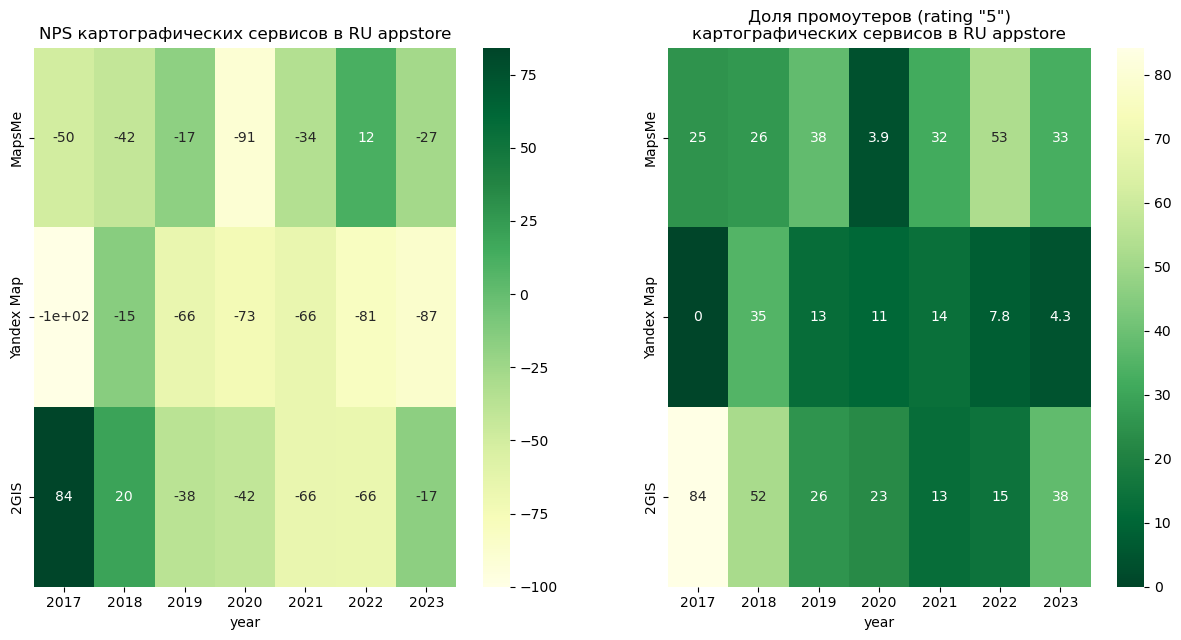

In [5]:
nps_by_year_maps = nps_by_year(maps)
nps_by_year_y = nps_by_year(yandex)
nps_by_year_dg = nps_by_year(t_gis)
# Тут объединение результатов 3 конкурентов
result_nps = pd.merge(nps_by_year_maps,
         nps_by_year_y,
         left_index=True,
         right_index=True,
         suffixes=('_mapsme','_ya')).join(nps_by_year_dg.rename(columns=lambda x: x + '_2g'))
# result_nps.to_csv(r'data/competitive_table/ru_segment.csv')


_,axes = plt.subplots(ncols=2,figsize=(15,7))
sns.heatmap(result_nps\
            .filter(regex='^nps_.+',axis=1)\
            .rename(
                    {'nps_mapsme':'MapsMe',
                    'nps_ya':'Yandex Map',
                    'nps_2g':'2GIS'},
                axis=1
                   ).T*100,
                annot=True,
                ax=axes[0],
                cmap='YlGn'
           )
axes[0].set_title('NPS картографических сервисов в RU appstore',fontsize=12)
sns.heatmap(result_nps\
            .filter(regex='^promoter_.+',axis=1)\
            .rename(
                    {'promoter_mapsme':'MapsMe',
                    'promoter_ya':'Yandex Map',
                    'promoter_2g':'2GIS'},
                axis=1
                   ).T*100,
                annot=True,
                cmap='YlGn_r',
                ax=axes[1]
           )
axes[1].set_title('Доля промоутеров (rating "5")\nкартографических сервисов в RU appstore',fontsize=12)
None


In [ ]:
result_nps

# Android

In [21]:
google_app_info = {
    'app_id':"com.mapswithme.maps.pro",
     'lang':'ru',
     'country':'us',
     'sort':Sort.NEWEST,
     'count':3
 }


In [22]:
result, _ = reviews(**google_app_info)

In [24]:
pd.DataFrame(result)

,reviewId,userName,userImage,content,score,thumbsUpCount,reviewCreatedVersion,at,replyContent,repliedAt,appVersion
0,1107c85e-f025-45f0-bb2f-d87b9a2f0e95,Denis Vasiliev,https://play-lh.googleusercontent.com/a/ACg8oc...,Пользуюсь maps.me более пяти лет и он всегда р...,1,48,v14.0.71350-googleRelease,2022-07-07 05:44:36,None,None,v14.0.71350-googleRelease
1,29b1f638-517a-4ab6-95b5-77ae1eb12335,Dmitry Menchikov,https://play-lh.googleusercontent.com/a/ACg8oc...,Год назад прекрасно работало. В лесу без интер...,3,14,12.3.3-Google,2022-06-30 12:19:00,None,None,12.3.3-Google
2,09544c7d-510d-4f8c-88f7-36a0bcb99c0b,Артур Гал,https://play-lh.googleusercontent.com/a/ACg8oc...,"Составляет маршрут не понятно как, из точки А ...",1,8,v15.7.71702-googleRelease,2024-02-21 10:47:14,None,None,v15.7.71702-googleRelease


# Rating and reviews' length

In [17]:
usa = pd.read_csv('data/usa_maps', parse_dates=['date'])
rus = pd.read_csv('data/ru_maps',parse_dates=['date'])
usa['source']='USA'
rus['source']='RU'
frame = pd.concat([usa,rus])
frame = frame.drop(columns=['Unnamed: 0','promoter','detractor'])
frame = parse_dates(frame)
frame['length'] = frame['review'].str.len()
frame['group'] = frame['length'].apply(
    lambda x: 'only rating' if x == 0 else ('detailed review' if x > 80 else 'review' ))

In [18]:
frame

,date,review,rating,isEdited,userName,title,developerResponse,month,year,source,length,group
0,2017-12-14,This free app is already at the top of the hea...,5,False,Casey In LA,no ads and in-app purchases! and yes it's rea...,NaN,2017-12-01,2017,USA,1030.0,detailed review
1,2023-10-01,"This used to be my favorite map app, but now a...",1,False,Somedayisnowrtw,Completely ruined from what it used to be,NaN,2023-10-01,2023,USA,1416.0,detailed review
2,2018-08-27,I just got back from a two week road trip in N...,5,False,Abby and Sydney,I love this app,NaN,2018-08-01,2018,USA,1015.0,detailed review
3,2023-06-24,This app used to be the best offline navigatio...,3,True,:(!:(!35&25&&/4,Used to be best offline navigation map,"{'id': 18053732, 'body': 'Voice instructions i...",2023-06-01,2023,USA,1089.0,detailed review
4,2022-04-28,I tried this app both offline and online in a ...,2,False,Thi-cot,Poor navigation,"{'id': 32034878, 'body': ""Good afternoon! Than...",2022-04-01,2022,USA,1219.0,detailed review
...,...,...,...,...,...,...,...,...,...,...,...,...
2135,2021-09-21,"Ещё бы добавили автобусные маршруты, а так все...",5,False,Leva28,Карты Кипра,NaN,2021-09-01,2021,RU,54.0,review
2136,2021-09-21,"Вчера скачала карту Дубая, через 15 минут карт...",2,False,Shamsinur^_^,"Тормозит, не загружает карты",NaN,2021-09-01,2021,RU,276.0,detailed review
2137,2021-09-20,"Для моряков, которые ходят по Европе и вообще ...",5,False,SvyatoslavOO867,Полезно круто,NaN,2021-09-01,2021,RU,95.0,detailed review
2138,2021-09-20,Не раз выручало,5,False,DophamineB,Спасибо создателям!,NaN,2021-09-01,2021,RU,15.0,review


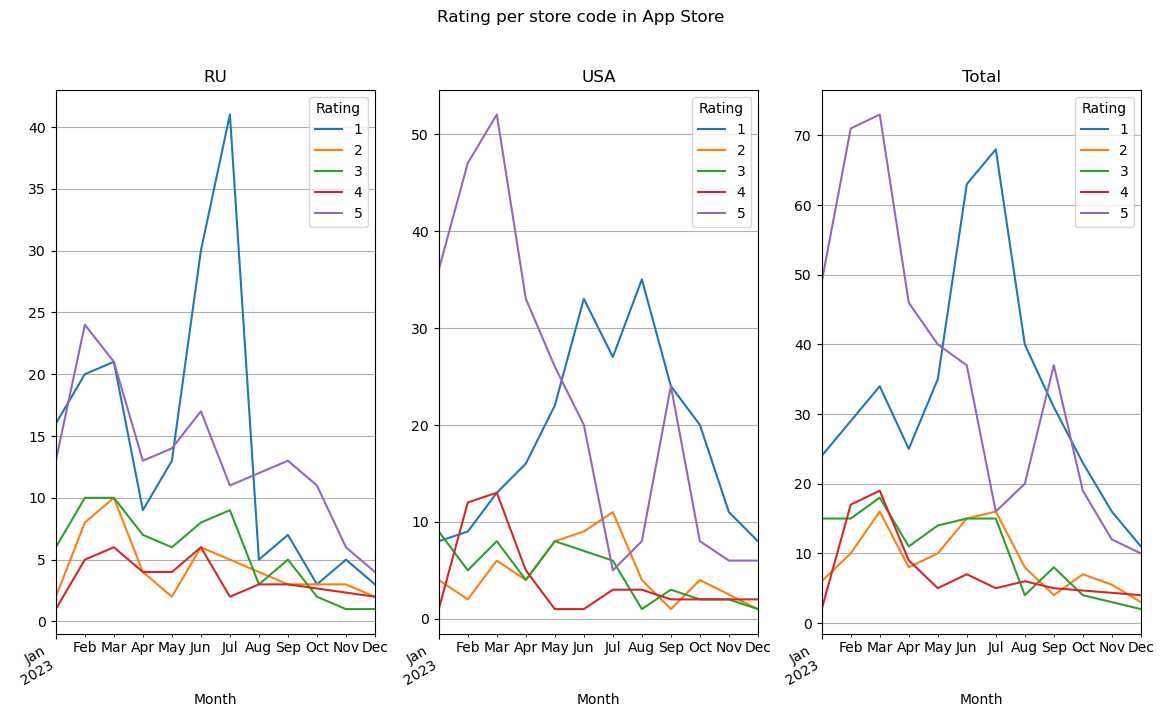

In [19]:
fig,axes = plt.subplots(ncols=3,figsize=(14,8))
fig.suptitle('Rating per store code in App Store')
#
rating_by_month = frame.query('year == 2023').pivot_table(index=['source','month'],columns='rating',aggfunc='size').interpolate(method ='linear', limit_direction ='forward')
rating_by_month.loc['RU'].plot(ax=axes[0],title='RU')
rating_by_month.loc['USA'].plot(ax=axes[1],title='USA')
rating_by_month.groupby('month').sum().plot(ax=axes[2],title='Total')
[(ax.set_xlabel('Month'),ax.legend(title='Rating'),ax.grid(True)) for ax in axes];
fig.autofmt_xdate()

In [ ]:
type_review_by_sc = frame.query('year == 2023').pivot_table(index=['source','month'],
                                        columns='group',
                                        aggfunc='size')
fig,axes = plt.subplots(ncols=3,figsize=(14,8))
fig.suptitle('Cumulative reviews per store code in App Store')
type_review_by_sc.loc['USA'].plot(ax=axes[0],title='USA')
type_review_by_sc.loc['RU'].plot(ax=axes[1],title='RU')
#
frame.query('year==2023').pivot_table(index=['month'],
                                      columns='group',
                                      aggfunc='size').cumsum().plot(ax=axes[2],title='Total')

[(ax.set_xlabel('Month'),ax.legend(title='Review type'),ax.grid(True)) for ax in axes];
None

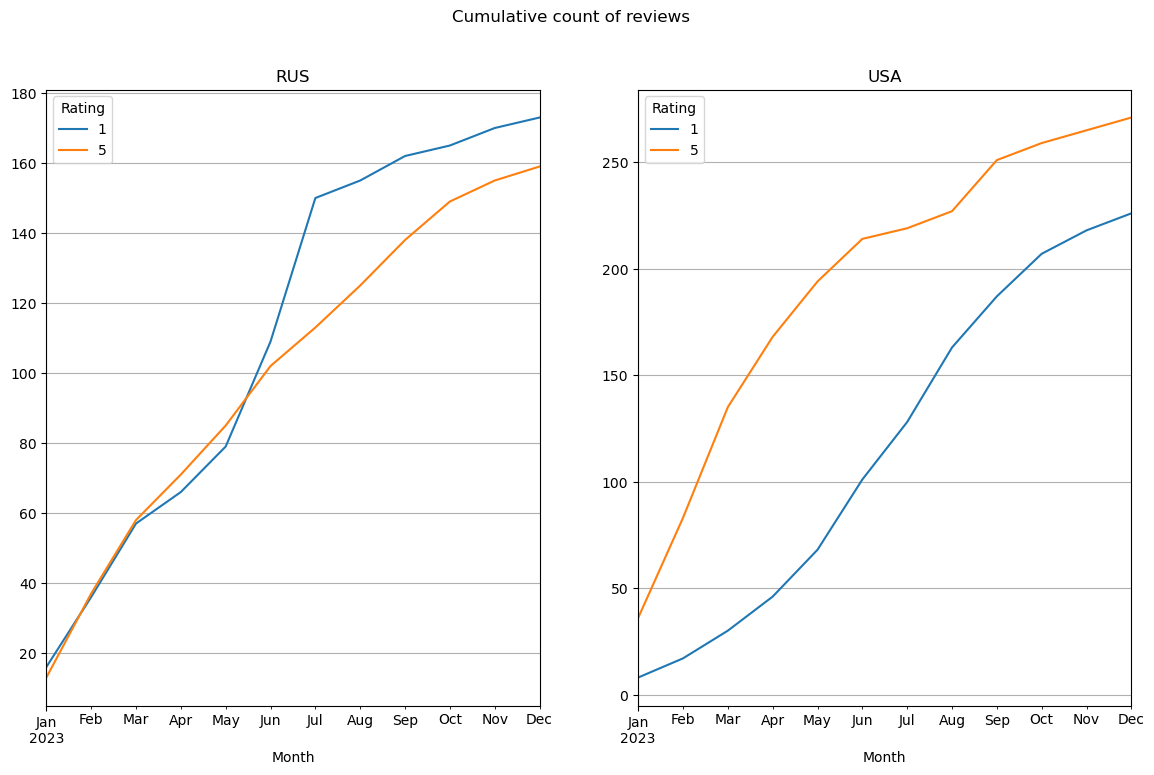

In [20]:
fig,axes = plt.subplots(ncols=2,figsize=(14,8))

fig.suptitle('Cumulative count of reviews')
frame.query('year==2023 and rating in (1,5)').pivot_table(index=['source','month'],
                                      columns='rating',
                                      aggfunc='size').loc['RU'].cumsum().plot(title='RUS',ax=axes[0])
#
frame.query('year==2023 and rating in (1,5)').pivot_table(index=['source','month'],
                                      columns='rating',
                                      aggfunc='size').loc['USA'].cumsum().plot(title='USA',ax=axes[1])

[(ax.set_xlabel('Month'),ax.legend(title='Rating'),ax.grid(True)) for ax in axes];
None

In [22]:
yandex['app']='Yandex'
t_gis['app']='2GIS'
con_frame = pd.concat([yandex,t_gis])
con_frame = con_frame.drop(columns=['Unnamed: 0'])
con_frame = parse_dates(con_frame)
con_frame['length'] = con_frame['review'].str.len()
con_frame['group'] = con_frame['length'].apply(
    lambda x: 'only rating' if x == 0 else ('detailed review' if x > 80 else 'review' ))
con_frame

,date,developerResponse,review,rating,isEdited,title,userName,month,year,promoter,detractor,app,length,group
0,2020-11-03,"{'id': 28779550, 'body': 'Данная ситуация испр...",Присоединяюсь к жалобам на огромное всплывающе...,5,False,Жалоба на всплывающее окно информации,tlukutuk,2020-11-01,2020,1,0,Yandex,239,detailed review
1,2020-07-03,"{'id': 40489851, 'body': 'Ситуация с долгим на...","Сделайте пожалуйста поддержку iOS 14! Там, при...",3,False,iOS 14,Лозовуша,2020-07-01,2020,0,1,Yandex,214,detailed review
2,2020-07-22,"{'id': 35115417, 'body': 'Спасибо за отзыв.\n\...",После обновления при малейшем касании карты вы...,2,False,Не возможно докоснуться до карты,ан136345,2020-07-01,2020,0,1,Yandex,185,detailed review
3,2019-02-08,"{'id': 38322996, 'body': 'Спасибо, что поделил...",дастала эта шторка снизу уберите ее. и эта дур...,1,False,дастала эта н,Ршммг,2019-02-01,2019,0,1,Yandex,125,detailed review
4,2019-03-24,"{'id': 35115430, 'body': 'Вопросы с панелями, ...",После последнего обновления появилась куча лиш...,2,False,Отзыв,Нож,2019-03-01,2019,0,1,Yandex,259,detailed review
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2495,2023-08-31,"{'id': 38791419, 'body': 'Такая ситуация может...",Не отображаются остановки,1,False,Испортили приложение,мама любит меня,2023-08-01,2023,0,1,2GIS,25,review
2496,2023-08-31,"{'id': 38658478, 'body': 'Увы, сейчас у нас и ...","Странное последнее обновление, переодически вы...",3,False,Обновление,Neix33,2023-08-01,2023,0,1,2GIS,335,detailed review
2497,2023-08-30,"{'id': 38658620, 'body': 'Проблема может быть ...",После обновления приложением стало неудобно по...,2,False,Не работает,Sivertsa,2023-08-01,2023,0,1,2GIS,181,detailed review
2498,2023-08-30,"{'id': 38796403, 'body': 'Увы, мы не можем вер...",Ужасное обновление. Такое классное приложение ...,1,False,Верните как было!,GeraRman,2023-08-01,2023,0,1,2GIS,59,review
